# Trajectory Analysis

In [1]:
import ampal
import nglview as nv

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

In [3]:
#my_protein = ampal.load_pdb('/home/eva/Documents/analysis/test.pdb')

In [4]:
#my_protein.sequences

Loading the trajectory and topology files:

In [5]:
traj = md.load('/home/eva/Documents/gbsa-sims/sims-1/tet_L24E/GLH/dcd/6q5i_GLH_output.dcd', top = '/home/eva/Documents/structures/tet_L24E/GLH/6q5i_GLH.prmtop')

In [6]:
#frame1 = md.load_frame('/home/eva/Documents/gbsa-sims/sims-1/tet_L24E/GLH/dcd/6q5i_GLH_output.dcd', 0, top = '/home/eva/Documents/structures/tet_L24E/GLH/6q5i_GLH.prmtop')

In [7]:
#frame1.save_pdb('test.pdb')

## Structure

Creating a function that will have a list and the number of chains as an input and will split that list according to the number of chains present in the structure:

In [8]:
#def assembly_splitter(lst, chain_no)

Separating the amino acids and the ACE-NH2 caps, and creating lists for their indexes:

In [9]:
res_obj = traj.topology.residues
res_list=[]
caps_positions =[]
all_residues=[]


for res in res_obj:
        all_residues.append(str(res))
        if res.name == 'ACE' or res.name == 'NHE':
            print('excluding the ACE and NH2 caps')
            caps_positions.append(str(res))
        else:
            res_list.append(str(res))
            
res_idx=[]
for res in res_list:
    res_idx.append(int(res[3:6]))
    
caps_idx=[]
for cap in caps_positions:
    caps_idx.append(int(cap[3:6]))
    
all_residues_idx=[]
for re in all_residues:
    all_residues_idx.append(int(re[3:6]))
    
#len(res_list)
#print(caps_positions)
#print(res_list)
#print(caps_idx)
#len(caps_idx)
#print(all_residues_idx)

excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps


Separating the individual chains (based on the positions of the caps):

In [10]:
chain_number = int(len(caps_idx)/2)
print('the number of chains in the structure is', chain_number)

the number of chains in the structure is 4


Separating the caps by type:

In [11]:
ace=caps_idx[0::2]
nh2=caps_idx[1::2]

In [12]:
chain_list=[]
chain=[]
chain_idx = []
all_idx=[]

for i in range(len(ace)):
    chain = all_residues[(ace[i]+1):(nh2[i])]
    chain_list.append(chain)
    chain=[]

for ch in chain_list:
    for re in ch:
        all_idx.append(int(re[3:6]))    

for i in range(len(ace)):
    chain = all_residues_idx[(ace[i]+1):(nh2[i])]
    chain_idx.append(chain)
    chain=[]

#print(all_idx)
#print(chain_idx)

We can view the sequence and residue indexes of a single chain with:

In [13]:
#chain_list[0]

In [14]:
#chain_idx[0]

## RMSD calculation

Getting the syntax for the atom expression:

In [15]:
selection = traj.topology.select_expression('backbone')
print(selection)

[atom.index for atom in topology.atoms if atom.is_backbone
]


Calculating the RMSD from the first frame (initial structure), for the backbone atoms:

In [16]:
rmsds = md.rmsd(traj, traj, 0, atom_indices = [a.index for a in traj.topology.atoms if a.is_backbone])

Creating an array for time (4 fs timestep, 200 ns simulation time):

In [17]:
t = np.arange(0.0, 200.0, 0.004)

Creating the RMSD plot:

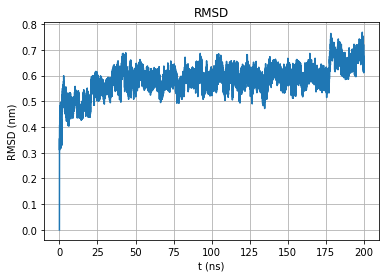

In [18]:
fig,ax = plt.subplots()
ax.plot(t, rmsds)
ax.set(xlabel='t (ns)', ylabel='RMSD (nm)', title='RMSD')
ax.grid()

fig.savefig('rmsd.png')
plt.show()

## RMSF calculation

Getting the syntax for the atom selection:

In [19]:
selection = traj.topology.select_expression('name CA')
print(selection)

[atom.index for atom in topology.atoms if (atom.name == 'CA')
]


Calculating the RMSF from the first frame (initial structure) for the CA atoms:

In [20]:
rmsfs = md.rmsf(traj, traj, 0, atom_indices = [a.index for a in traj.topology.atoms if a.name == 'CA'])

Creating the RMSF plot (per assembly): 

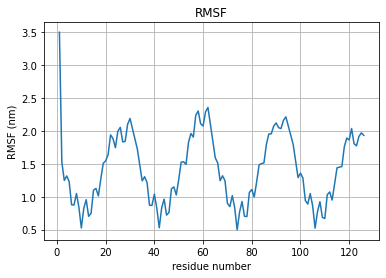

In [21]:
fig,ax = plt.subplots()
ax.plot(res_idx, rmsfs)
ax.set(xlabel='residue number', ylabel='RMSF (nm)', title='RMSF')
ax.grid()

fig.savefig('rmsf.png')
plt.show()

Creating the RMSF plot per chain (example: first chain)

In [22]:
chain_length = len(chain_idx[0])

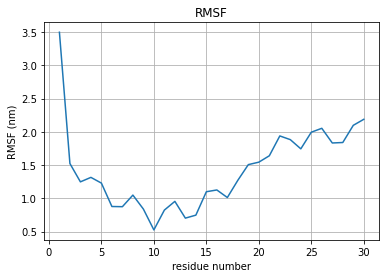

In [43]:
fig,ax = plt.subplots()
ax.plot(chain_idx[0], rmsfs[0*chain_length:1*chain_length])
ax.set(xlabel='residue number', ylabel='RMSF (nm)', title='RMSF')
ax.grid()

fig.savefig('rmsf-per-chain-1.png')
plt.show()

In [24]:
#rmsfs[chain_length:2*chain_length] #second chain

In [25]:
#rmsfs[2*chain_length:3*chain_length] #third chain, and so on...

## Secondary structure calculation

In [26]:
sec_struct = md.compute_dssp(traj, simplified = False)
print(sec_struct)

[['NA' ' ' 'H' ... 'H' ' ' 'NA']
 ['NA' ' ' 'H' ... 'T' ' ' 'NA']
 ['NA' ' ' 'T' ... 'H' ' ' 'NA']
 ...
 ['NA' ' ' 'T' ... ' ' ' ' 'NA']
 ['NA' ' ' 'T' ... ' ' ' ' 'NA']
 ['NA' ' ' 'T' ... ' ' ' ' 'NA']]


Simplified secondary structure: H = helix, C = coil, E = strand

In [27]:
sec_struct_simple = md.compute_dssp(traj, simplified=True)
print(sec_struct_simple)

[['NA' 'C' 'H' ... 'H' 'C' 'NA']
 ['NA' 'C' 'H' ... 'C' 'C' 'NA']
 ['NA' 'C' 'C' ... 'H' 'C' 'NA']
 ...
 ['NA' 'C' 'C' ... 'C' 'C' 'NA']
 ['NA' 'C' 'C' ... 'C' 'C' 'NA']
 ['NA' 'C' 'C' ... 'C' 'C' 'NA']]


In [28]:
frames = len(sec_struct_simple)
print('the number of frames is', frames)

the number of frames is 50000


Saving the secondary structure of each residue in the struct_list:

In [29]:
idx = 0
struct_list=[]
resid_list=[]
aa = len(all_residues) #the number of total residues in the assembly

for idx in range(0, aa):
    for frame in sec_struct_simple:
        resid_list.append(frame[idx])
    struct_list.append(resid_list)
    resid_list=[]

Getting the secondary structure of the i-th residue with struct_list[i-1] (across the whole simulation):

In [30]:
#print(struct_list[9])
#print(len(struct_list[9]))

Note that this includes the ACE and NH2 caps (sec. struct 'NA').

### Helicity per residue calculation

The res_list contains all residues with their residue number, whereas the res_idx contains just the residue number (ACE and NH2 caps excluded)

In [31]:
#print(res_list)
#print(res_idx)

Calculating the helicity per residue - excluding caps:

In [32]:
count = 0
helicity_per_residue = []
helicity = 0

for res in struct_list:
    if 'NA' in res:
        print('excluding the ACE and NH2 caps')   
    else:
        for snapshot in res:
            if snapshot == 'H':
                count+=1
            helicity = (count/frames)*100
        helicity_per_residue.append(helicity)
        count=0

excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps
excluding the ACE and NH2 caps


In [33]:
#len(helicity_per_residue)
#print(helicity_per_residue)

Creating the %helicity per residue plot:

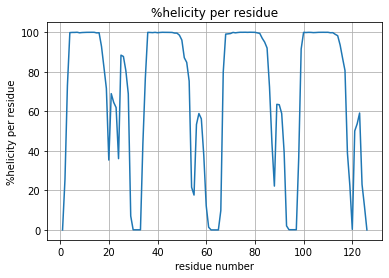

In [34]:
fig,ax = plt.subplots()
ax.plot(res_idx, helicity_per_residue)
ax.set(xlabel='residue number', ylabel='%helicity per residue', title='%helicity per residue')
ax.grid()

fig.savefig('hpr.png')
plt.show()

### Helicity per chain calculation

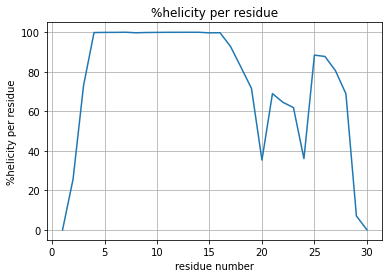

In [48]:
fig,ax = plt.subplots()
ax.plot(chain_idx[0], helicity_per_residue[0*chain_length:1*chain_length])
ax.set(xlabel='residue number', ylabel='%helicity per residue', title='%helicity per residue')
ax.grid()

fig.savefig('hpr-per-chain-1.png')
plt.show()

Helicity per residue plot - all individual chains in one graph

## Hydrogen bonds calculation

Each row in the resulting array contains the donor atom, the hydrogen atom and the acceptor atom indices.

In [36]:
hbonds = md.baker_hubbard(traj, freq=0.1, exclude_water=True, periodic=False, sidechain_only=False, distance_cutoff=0.25, angle_cutoff=120)

print(hbonds)

[[  13   14   24]
 [  29   30  875]
 [  29   30  876]
 [  48   49   12]
 [  48   49  875]
 [  70   71   12]
 [  70   71   28]
 [  80   81   28]
 [  80   81   47]
 [  99  100   47]
 [ 121  123   69]
 [ 109  110   69]
 [ 126  127   79]
 [ 126  127   98]
 [ 142  143   98]
 [ 161  162  108]
 [ 183  184  125]
 [ 183  184  141]
 [ 193  194  141]
 [ 193  194  160]
 [ 212  213  160]
 [ 222  223  182]
 [ 222  223  192]
 [ 244  245  192]
 [ 244  245  211]
 [ 260  261  211]
 [ 279  280  221]
 [ 279  280  243]
 [ 301  302  243]
 [ 301  302  259]
 [ 311  312  259]
 [ 311  312  278]
 [ 330  331  278]
 [ 330  331  300]
 [ 330  331  310]
 [ 350  351  310]
 [ 340  341  300]
 [ 364  365  310]
 [ 364  365  329]
 [ 380  381  329]
 [ 380  381  339]
 [ 396  397  339]
 [ 396  397  379]
 [ 418  419  363]
 [ 418  419  379]
 [ 418  419 1395]
 [ 418  419 1414]
 [ 428  429  379]
 [ 428  429  395]
 [ 447  448  395]
 [ 447  448  417]
 [ 457  458  417]
 [ 474  475  417]
 [ 490  491  456]
 [ 497  498  480]
 [ 513  51

In [37]:
label = lambda hbond : '%s -- %s' % (traj.topology.atom(hbond[0]), traj.topology.atom(hbond[2]))

In [38]:
for hbond in hbonds:
    print (label(hbond))

GLH2-N -- GLH2-OE1
LEU3-N -- GLH56-OE1
LEU3-N -- GLH56-OE2
LYS4-N -- GLY1-O
LYS4-N -- GLH56-OE1
ALA5-N -- GLY1-O
ALA5-N -- GLH2-O
ILE6-N -- GLH2-O
ILE6-N -- LEU3-O
ALA7-N -- LEU3-O
GLN8-NE2 -- LYS4-O
GLN8-N -- LYS4-O
GLH9-N -- ALA5-O
GLH9-N -- ILE6-O
LEU10-N -- ILE6-O
LYS11-N -- ALA7-O
ALA12-N -- GLN8-O
ALA12-N -- GLH9-O
ILE13-N -- GLH9-O
ILE13-N -- LEU10-O
ALA14-N -- LEU10-O
LYS15-N -- LYS11-O
LYS15-N -- ALA12-O
GLH16-N -- ALA12-O
GLH16-N -- ILE13-O
LEU17-N -- ILE13-O
LYS18-N -- ALA14-O
LYS18-N -- LYS15-O
ALA19-N -- LYS15-O
ALA19-N -- GLH16-O
ILE20-N -- GLH16-O
ILE20-N -- LEU17-O
ALA21-N -- LEU17-O
ALA21-N -- LYS18-O
ALA21-N -- ALA19-O
TRP22-NE1 -- ALA19-O
TRP22-N -- LYS18-O
GLH23-N -- ALA19-O
GLH23-N -- ILE20-O
GLH24-N -- ILE20-O
GLH24-N -- ALA21-O
LYS25-N -- ALA21-O
LYS25-N -- GLH23-O
ALA26-N -- TRP22-O
ALA26-N -- GLH23-O
ALA26-N -- ALA90-O
ALA26-N -- ILE91-O
ILE27-N -- GLH23-O
ILE27-N -- GLH24-O
ALA28-N -- GLH24-O
ALA28-N -- LYS25-O
GLN29-N -- LYS25-O
GLY30-N -- LYS25-O
GLY33-N -- 

## 